<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [ ]:
!nvidia-smi

Sat May 29 09:19:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
!pip install SimpleITK
%cd /content/segmentation-of-pelvic-bone/src

Cloning into 'segmentation-of-pelvic-bone'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 318 (delta 187), reused 179 (delta 88), pack-reused 0
Receiving objects: 100% (318/318), 6.36 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (187/187), done.
     |████████████████████████████████| 47.4MB 107kB/s 
/content/segmentation-of-pelvic-bone/src


In [ ]:
!git pull

Already up to date.


In [ ]:
import sys
sys.path.append('../src/')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [ ]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

# DenseNet


In [ ]:
input = tfkl.Input([None, None, 3])
x = tf.cast(input, tf.float32)
x = tf.image.per_image_standardization(x)
densenet_model = tfk.applications.DenseNet121(weights="imagenet", include_top=False, pooling="max")
densenet_output = densenet_model(x)
hidden_layer = tfkl.Dense(1024, activation='relu')(densenet_output)
hl_reg = tfkl.Dropout(0.5)(hidden_layer)
# hl_bn = tfkl.BatchNormalization()(hl_reg)
hidden_layer = tfkl.Dense(512, activation='relu')(hl_reg)
hl_reg = tfkl.Dropout(0.5)(hidden_layer)
# hl_bn = tfkl.BatchNormalization()(hl_reg)
# hidden_layer = tfkl.Dense(64, activation='relu')(hl_bn)
# hl_reg = tfkl.Dropout(0.5)(hidden_layer)
# hl_bn = tfkl.BatchNormalization()(hl_reg)
# hidden_layer = tfkl.Dense(128, activation='relu')(hl_reg)
# hl_reg = tfkl.Dropout(0.5)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [ ]:
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast_21 (TFOpLambda)      (None, None, None, 3)     0         
_________________________________________________________________
tf.image.per_image_standardi (None, None, None, 3)     0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_61 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_34 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262

In [ ]:
densenet_model.trainable = False
for layer in densenet_model.layers:
    layer.trainable = False

# cycles_n = 3
# epochs = 30
# steps_per_epoch = 26
# step_size = epochs * steps_per_epoch / (cycles_n*2)

# lr = tfa.optimizers.CyclicalLearningRate(
#                 initial_learning_rate=1e-5,
#                 maximal_learning_rate=1e-2,
#                 step_size=step_size,
#                 scale_fn=lambda x: 1.0
#             )
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics=['acc'])

In [ ]:
!rm -r /content/drive/MyDrive/KTH/HL2027/checkpoint/densenet/*
!ls  /content/drive/MyDrive/KTH/HL2027/checkpoint/densenet

In [ ]:
checkpoint_filepath = PATH + '/checkpoint/densenet/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/30
26/26 [==============================] - 9s 129ms/step - loss: 1.9643 - acc: 0.8123 - val_loss: 0.7792 - val_acc: 0.8837
Epoch 2/30
26/26 [==============================] - 2s 66ms/step - loss: 0.5880 - acc: 0.8736 - val_loss: 0.0661 - val_acc: 1.0000
Epoch 3/30
26/26 [==============================] - 2s 66ms/step - loss: 0.2805 - acc: 0.9080 - val_loss: 0.0556 - val_acc: 1.0000
Epoch 4/30
26/26 [==============================] - 2s 66ms/step - loss: 0.2191 - acc: 0.9215 - val_loss: 0.0264 - val_acc: 1.0000
Epoch 5/30
26/26 [==============================] - 2s 66ms/step - loss: 0.1579 - acc: 0.9374 - val_loss: 0.0259 - val_acc: 1.0000
Epoch 6/30
26/26 [==============================] - 2s 66ms/step - loss: 0.0757 - acc: 0.9693 - val_loss: 0.0394 - val_acc: 1.0000
Epoch 7/30
26/26 [==============================] - 2s 66ms/step - loss: 0.0753 - acc: 0.9755 - val_loss: 0.0184 - val_acc: 1.0000
Epoch 8/30
26/26 [==============================] - 2s 66ms/step - loss: 0.1134 - 

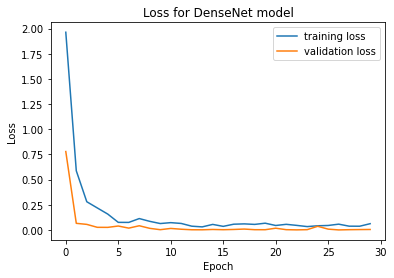

In [ ]:
  plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss for DenseNet model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f'{PATH}/images/lossbest.png')
plt.show()

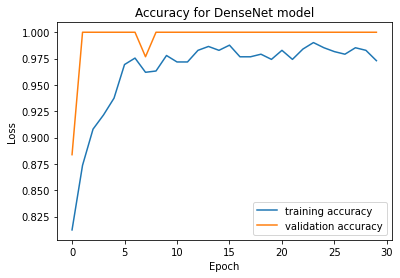

In [ ]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title("Accuracy for DenseNet model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f'{PATH}/images/accbest.png')
plt.show()

In [ ]:
model.save(PATH + '/checkpoint/densenet/200/')

INFO:tensorflow:Assets written to: /content/drive/My Drive/KTH/HL2027//checkpoint/densenet/200/assets


## Test Performance

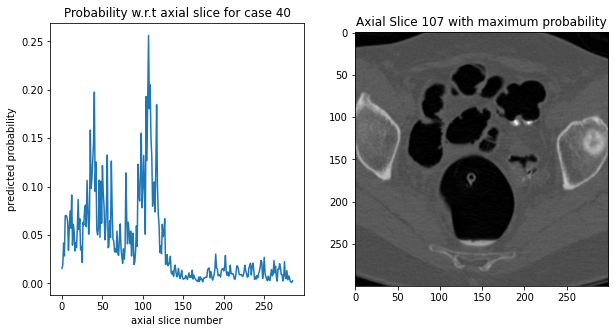

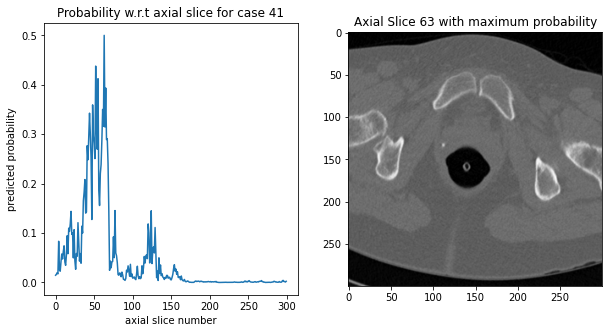

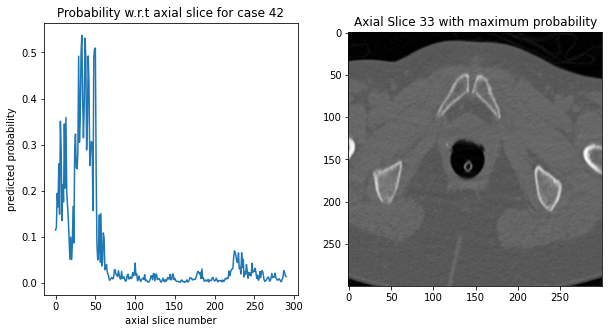

CPU times: user 4.57 s, sys: 270 ms, total: 4.84 s
Wall time: 4.39 s


In [ ]:
%%time
for id, cmn_img in data.cmn_img_3c.items():
  # X_flat = np.array([x.flatten() for x in cmn_img])
  # X_flat = data.scaler.transform(X_flat)
  # X = X_flat.reshape(cmn_img.shape)
  # X = np.array(
  #           [np.repeat(x[None, ...], 3, axis=0).T for x in X])
  X_test = tf.image.per_image_standardization(cmn_img)
  y_pred = model.predict(X_test)
  argmax = np.argmax(y_pred)
  plt.figure(figsize=(10,5))

  plt.subplot(121)
  plt.plot(y_pred)
  plt.xlabel("axial slice number")
  plt.ylabel("predicted probability")
  plt.title(f"Probability w.r.t axial slice for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.title(f"Axial Slice {argmax} with maximum probability")
  # plt.savefig(f'{PATH}/images/best_densenet_{id}.png')
  plt.show()